 # Performance tests for full-text search

In [1]:
# Imports
import nltk
import nltk.tokenize
import psycopg2
from random import randint
import re
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import requests.auth
import json

try:
    import config  # Try to import attributes from config.py
except Exception as e:  # If no config.py, define Object with empty attributes
    print('Warning: No config.py found. ' +
          'Using empty values for non-provided connection attributes. ' +
          str(e))

    class Object(object):
        """Dummy class for config attributes."""
        pass

    config = Object()
    config.HOSTNAME = ''
    config.PORT = -1
    config.DBNAME = ''
    config.USERNAME = ''
    config.PASSWORD = ''

nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/andre/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Estabilishing connection to database
conn = psycopg2.connect(host=config.HOSTNAME,
                        port=config.PORT,
                        dbname=config.DBNAME,
                        user=config.USERNAME,
                        password=config.PASSWORD)
cur = conn.cursor()
cur.close()


In [3]:
# Preparing for N queries
times = []
labels = []

N = 100

# Using a random sentence from the dataset
cur = conn.cursor()
cur.execute("""SELECT array_to_string(answers, chr(10)) as answers FROM interviews LIMIT 18;""")
result = '\n'.join([i[0] for i in cur.fetchall()])
cur.close()
conn.rollback()

sents = nltk.tokenize.sent_tokenize(result.replace('\n', '; '), language='portuguese')

# filtering too long/specific sentences (arbitrary threshold to possibly recover more than just one interview)
sents = [i.replace('; ', '') for i in sents]


In [4]:
# Number of sentences
print(len(sents))

2692


In [5]:
# Average number of words per sentence
print(sum([len(i.split()) for i in sents]) / len(sents))

42.928306092124814


In [6]:
# Print random sentence
print(sents[randint(0, len(sents)-1)])

Assim, não tem nem o que falar – ganhar o Pan já foi o máximo, porque foi muito gostoso.


 ## Testing example of query plan

In [7]:
cur = conn.cursor()
cur.execute(
    """EXPLAIN (ANALYZE TRUE, TIMING FALSE)
            SELECT id, text, questions, answers, meta,
                            ts_rank_cd(tstext,
                                       websearch_to_tsquery('portuguese',
                                                            %(search_string)s),
                                        1|4|32)
                                as rank
                        FROM interviews
                        WHERE tstext @@
                            websearch_to_tsquery('portuguese',
                                                 %(search_string)s)
                        ORDER BY rank DESC;
    """, {"search_string": sents[randint(0, len(sents)-1)]})
result = cur.fetchall()
print(*result, sep='\n')
print('Execution time: ', float(re.findall(r"\d+\.\d+", result[len(result)-1][0])[0]))
cur.close()
conn.rollback()


('Sort  (cost=3837.48..3862.53 rows=10018 width=480) (actual rows=10018 loops=1)',)
("  Sort Key: (ts_rank_cd(tstext, '''ah'' & ''gent'' & ''comec'' & ''particip'' & ''primeir'' & ''campeonat'''::tsquery, 37)) DESC",)
('  Sort Method: external merge  Disk: 4824kB',)
('  ->  Seq Scan on interviews  (cost=0.00..1012.27 rows=10018 width=480) (actual rows=10018 loops=1)',)
("        Filter: (tstext @@ '''ah'' & ''gent'' & ''comec'' & ''particip'' & ''primeir'' & ''campeonat'''::tsquery)",)
('Planning Time: 3.385 ms',)
('Execution Time: 751.690 ms',)
Execution time:  751.69


## Query 1: Using LIKE operator, without full-text search functionalities
Note: in this query, ranking by relevance is not available

In [8]:
cur = conn.cursor()
cur.execute('SET enable_seqscan=true')
cur.execute('drop index interviews_idx_tstext;')
cur.execute(
    """EXPLAIN (ANALYZE TRUE, TIMING FALSE)
            SELECT id, text, questions, answers, meta
                        FROM interviews
                        WHERE text LIKE %(search_string)s;
    """, {"search_string": '%' + sents[randint(0, len(sents)-1)] + '%'})
result = cur.fetchall()
print(*result, sep='\n')
print('Execution time: ', float(re.findall(r"\d+\.\d+", result[len(result)-1][0])[0]))
cur.close()
conn.rollback()


('Seq Scan on interviews  (cost=0.00..987.23 rows=1 width=476) (actual rows=518 loops=1)',)
("  Filter: (text ~~ '%Mas nossa dá muita saudade é às vezes a gente quer voltar no tempo para voltar tudo aquilo de novo.%'::text)",)
('  Rows Removed by Filter: 9500',)
('Planning Time: 0.101 ms',)
('Execution Time: 1948.749 ms',)
Execution time:  1948.749


In [9]:
# Getting execution times
cur = conn.cursor()
cur.execute('SET enable_seqscan=true')
cur.execute('drop index interviews_idx_tstext;')
aux = []
for i in range(N):
    cur.execute(
        """EXPLAIN (ANALYZE TRUE, TIMING FALSE)
            SELECT id, text, questions, answers, meta
                        FROM interviews
                        WHERE text LIKE %(search_string)s;
    """, {"search_string": '%' + sents[randint(0, len(sents)-1)] + '%'})
    result = cur.fetchall()
    aux.append(float(re.findall(r"\d+\.\d+", result[len(result)-1][0])[0]))
cur.close()
conn.rollback()
times.append(aux)
labels.append("Operador LIKE")


## Query 2: Using @@ operator, without tsvector index

In [10]:
cur = conn.cursor()
cur.execute('SET enable_seqscan=true')
cur.execute('drop index interviews_idx_tstext;')
cur.execute(
    """EXPLAIN (ANALYZE TRUE, TIMING FALSE)
            SELECT id, text, questions, answers, meta,
                            ts_rank_cd(tstext,
                                       websearch_to_tsquery('portuguese',
                                                            %(search_string)s),
                                        1|4|32)
                                as rank
                        FROM interviews
                        WHERE tstext @@
                            websearch_to_tsquery('portuguese',
                                                 %(search_string)s)
                        ORDER BY rank DESC;
    """, {"search_string": sents[randint(0, len(sents)-1)]})
result = cur.fetchall()
print(*result, sep='\n')
print('Execution time: ', float(re.findall(r"\d+\.\d+", result[len(result)-1][0])[0]))
cur.close()
conn.rollback()


('Sort  (cost=1171.50..1179.13 rows=3052 width=480) (actual rows=1073 loops=1)',)
("  Sort Key: (ts_rank_cd(tstext, '''aí'' & ''volt'' & ''trein'' & ''tal'' & ''né'''::tsquery, 37)) DESC",)
('  Sort Method: quicksort  Memory: 1178kB',)
('  ->  Seq Scan on interviews  (cost=0.00..994.86 rows=3052 width=480) (actual rows=1073 loops=1)',)
("        Filter: (tstext @@ '''aí'' & ''volt'' & ''trein'' & ''tal'' & ''né'''::tsquery)",)
('        Rows Removed by Filter: 8945',)
('Planning Time: 0.169 ms',)
('Execution Time: 288.978 ms',)
Execution time:  288.978


In [11]:
# Getting execution times
cur = conn.cursor()
cur.execute('SET enable_seqscan=true')
cur.execute('drop index interviews_idx_tstext;')
aux = []
for i in range(N):
    cur.execute(
        """EXPLAIN (ANALYZE TRUE, TIMING FALSE)
            SELECT id, text, questions, answers, meta,
                            ts_rank_cd(tstext,
                                       websearch_to_tsquery('portuguese',
                                                            %(search_string)s),
                                        1|4|32)
                                as rank
                        FROM interviews
                        WHERE tstext @@
                            websearch_to_tsquery('portuguese',
                                                 %(search_string)s)
                        ORDER BY rank DESC;
    """, {"search_string": sents[randint(0, len(sents)-1)]})
    result = cur.fetchall()
    aux.append(float(re.findall(r"\d+\.\d+", result[len(result)-1][0])[0]))
cur.close()
conn.rollback()
times.append(aux)
labels.append("Operador @@")

## Query 3: Using @@ operator, forcing usage of tsvector index

In [12]:
cur = conn.cursor()
cur.execute('SET enable_seqscan=false')
cur.execute('alter table interviews drop constraint interviews_pkey cascade;')
cur.execute(
    """EXPLAIN (ANALYZE TRUE, TIMING FALSE)
            SELECT id, text, questions, answers, meta,
                            ts_rank_cd(tstext,
                                       websearch_to_tsquery('portuguese',
                                                            %(search_string)s),
                                        1|4|32)
                                as rank
                        FROM interviews
                        WHERE tstext @@
                            websearch_to_tsquery('portuguese',
                                                 %(search_string)s)
                        ORDER BY rank DESC;
    """, {"search_string": sents[randint(0, len(sents)-1)]})
result = cur.fetchall()
print(*result, sep='\n')
print('Execution time: ', float(re.findall(r"\d+\.\d+", result[len(result)-1][0])[0]))
cur.close()
conn.rollback()


('Sort  (cost=1093.73..1098.03 rows=1722 width=480) (actual rows=2255 loops=1)',)
("  Sort Key: (ts_rank_cd(tstext, '''aí'' & ''volt'' & ''aí'' & ''fiqu'' & ''faz'' & ''fortalec'' & ''tal'''::tsquery, 37)) DESC",)
('  Sort Method: quicksort  Memory: 1392kB',)
('  ->  Bitmap Heap Scan on interviews  (cost=113.34..1001.17 rows=1722 width=480) (actual rows=2255 loops=1)',)
("        Recheck Cond: (tstext @@ '''aí'' & ''volt'' & ''aí'' & ''fiqu'' & ''faz'' & ''fortalec'' & ''tal'''::tsquery)",)
('        Heap Blocks: exact=785',)
('        ->  Bitmap Index Scan on interviews_idx_tstext  (cost=0.00..112.91 rows=1722 width=0) (actual rows=2255 loops=1)',)
("              Index Cond: (tstext @@ '''aí'' & ''volt'' & ''aí'' & ''fiqu'' & ''faz'' & ''fortalec'' & ''tal'''::tsquery)",)
('Planning Time: 0.671 ms',)
('Execution Time: 174.673 ms',)
Execution time:  174.673


In [13]:
# Getting execution times
cur = conn.cursor()
cur.execute('SET enable_seqscan=false')
cur.execute('alter table interviews drop constraint interviews_pkey cascade;')
aux = []
for i in range(N):
    cur.execute(
        """EXPLAIN (ANALYZE TRUE, TIMING FALSE)
            SELECT id, text, questions, answers, meta,
                            ts_rank_cd(tstext,
                                       websearch_to_tsquery('portuguese',
                                                            %(search_string)s),
                                        1|4|32)
                                as rank
                        FROM interviews
                        WHERE tstext @@
                            websearch_to_tsquery('portuguese',
                                                 %(search_string)s)
                        ORDER BY rank DESC;
    """, {"search_string": sents[randint(0, len(sents)-1)]})
    result = cur.fetchall()
    aux.append(float(re.findall(r"\d+\.\d+", result[len(result)-1][0])[0]))
cur.close()
conn.rollback()
times.append(aux)
labels.append("Operador @@, com índice")


## Query 4: Using @@ operator, with access through the API

In [14]:
# creating API user
headers = {'Content-type': 'application/json'}
req = requests.post('http://localhost:5000/users',
                    auth=requests.auth.HTTPBasicAuth('api_admin', 'api_admin'),
                    data=json.dumps({
                        'new_username': 'test',
                        'new_password': 'test'
                    }),
                    headers=headers)
print('Status code: ', req.status_code)
print('JSON response: ', req.json())


Status code:  201
JSON response:  {'message': 'API user created successfully.', 'username': 'test'}


In [38]:
# %%
# getting data from API
import time
time_begin = time.time()
req = requests.get('http://localhost:5000/interviews/' + sents[randint(0, len(sents)-1)],
                   auth=requests.auth.HTTPBasicAuth('test', 'test'))
time_end = time.time()
times_request = [time_begin, req.json()['time_request'], req.json()['time_prequery'], req.json()['time_execution'], req.json()['time_postquery'], req.json()['time_postmeta'], time_end]

t0 = 0 + times_request[0]
times_request[:3] = [(i - t0) * 1000 for i in times_request[:3]]
tq = 0 + times_request[3]
times_request[3] += times_request[2]
times_request[4:] = [((i - t0) * 1000) - tq for i in times_request[4:]]
print('Status code: ', req.status_code)
print('Elapsed time: ', req.elapsed.total_seconds() * 1000)
print('Times: ', times_request)


Status code:  200
Elapsed time:  1065.95
Times:  [0.0, 22.208690643310547, 22.237539291381836, 135.72853929138182, 952.2855865325928, 952.7993785705567, 954.2120086517334]


In [ ]:
aux = []
for i in range(N):
    time_begin = time.time()
    req = requests.get('http://localhost:5000/interviews/' + sents[randint(0, len(sents)-1)],
                       auth=requests.auth.HTTPBasicAuth('test', 'test'))
    time_end =time.time()
    times_request = [time_begin, req.json()['time_request'], req.json()['time_prequery'], req.json()['time_execution'], req.json()['time_postquery'], req.json()['time_postmeta'], time_end]

    t0 = 0 + times_request[0]
    times_request[:3] = [(i - t0) * 1000 for i in times_request[:3]]
    tq = 0 + times_request[3]
    times_request[3] += times_request[2]
    times_request[4:] = [((i - t0) * 1000) - tq for i in times_request[4:]]
    aux.append(times_request)
times.append(aux)
labels.append("API")
api_labels = ['Requisição', 'Início', 'Pré-query', 'Execução', 'Transmissão', 'Pós-metadata', 'Resposta']

## Graph comparison

In [41]:
print('Average access times (ms): ')
for i in range(len(times)-1):
    print(labels[i], '%.5f' % (sum(times[i]) / N), sep='\t\t')

Average access times (ms): 
Operador LIKE		1950.00210
Operador @@		496.94570
Operador @@, com índice		251.78412


[]

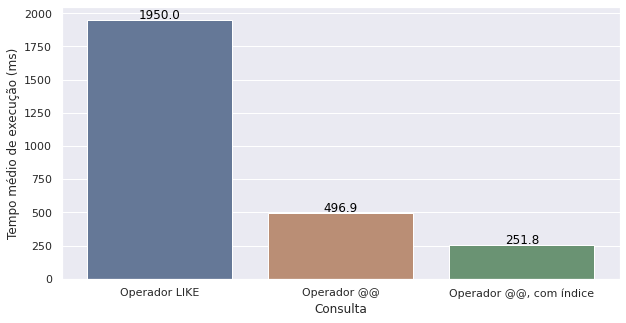

In [103]:
import numpy as np
import pandas as pd

arr = np.array(times[:3]).T
df = pd.DataFrame(arr, columns=labels[:3])

sns.set()
plt.figure(figsize=(10, 5))
#g = sns.barplot(data = times, units='ms')
g = sns.barplot(data=df, units='ms', capsize=0.1, saturation=0.5, ci=None)
# g.set(yscale="log")
for idx, i in enumerate(df.mean()):
    g.text(idx, i+10, round(i, 1), color='black', ha="center")
# plt.title("Comparação de desempenho para consultas sobre entrevistas (N=100)")
plt.xlabel("Consulta")
plt.ylabel("Tempo médio de execução (ms)")
plt.savefig('./perf.png')
plt.plot()

[]

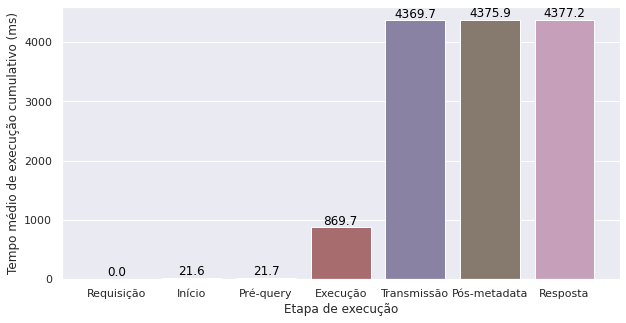

In [105]:
df2 = pd.DataFrame(times[3], columns = api_labels)

import math
sns.set()
plt.figure(figsize=(10, 5))
#g = sns.barplot(data = times, units='ms')
g = sns.barplot(data=df2, units='ms', capsize=0.1, saturation=0.5, ci=None)
# g.set(yscale="log")
for idx, i in enumerate(df2.mean()):
    g.text(idx, i+50, round(i, 1), color='black', ha="center")
# plt.title("Comparação de desempenho para consultas sobre entrevistas (N=100)")
plt.xlabel("Etapa de execução")
plt.ylabel("Tempo médio de execução cumulativo (ms)")
plt.savefig('./perf_api.png')
plt.plot()